In [1]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
from io import StringIO
import scipy

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', None)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
from IPython.core.display import Image

from perturbseq_v3 import *
from umap import UMAP

In [2]:
# Set up plotting settings
almost_black = '#262626'

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'light'
plt.rcParams['text.color'] = almost_black

axisLineWidth = .5
plt.rcParams['axes.linewidth'] = axisLineWidth
plt.rcParams['lines.linewidth'] = 1.5

plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handletextpad'] = .25
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.color'] = almost_black
plt.rcParams['ytick.major.width'] = axisLineWidth
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.color'] = almost_black
plt.rcParams['xtick.major.width'] = axisLineWidth

def plotGrid(axis, vert_origin = True, horiz_origin=True, unity=True):
    ylim = axis.get_ylim()
    xlim = axis.get_xlim()
    if vert_origin:
        axis.plot((0,0), ylim, color='#BFBFBF', lw=.5, alpha=.5) 
    if horiz_origin:
        axis.plot(xlim,(0,0), color='#BFBFBF', lw=.5, alpha=.5) 
    if unity:
        xmin = min(xlim[0], ylim[0])
        xmax = max(xlim[1], ylim[1])
        axis.plot((xmin,xmax),(xmin,xmax), color='#BFBFBF', lw=.5, alpha=.5) 
        axis.plot((xmin,xmax),(-xmin,-xmax), color='#BFBFBF', lw=.5, alpha=.5) 

    axis.set_ylim(ylim)
    axis.set_xlim(xlim)

In [3]:
# Load the cell population using methods from: https://github.com/thomasmaxwellnorman/perturbseq_demo

pop = CellPopulation.from_file('perturbseq_data/',
                               genome='GRCh38', version='v3', direct_capture=False)

Loading digital expression data: perturbseq_data/outs/filtered_feature_bc_matrix/matrix.mtx.gz...
Densifying matrix...
Loading guide identities:perturbseq_data/outs/cell_identities.csv...
Generating summary statistics...
Done.


In [4]:
# Select the single cells

pop = pop.subpopulation(cells='single_cell')

Generating summary statistics...
Done.


In [5]:
pop.cells.tail()

,guide_identity,guide_read_count,guide_UMI_count,guide_coverage,gemgroup,good_coverage,number_of_cells,guide_target,single_cell,UMI_count,gem_group
cell_barcode,,,,,,,,,,,
TTTGTTGAGGTTAGTA-8,negative_control_non-targeting_00721,1600.0000,20.0000,80.0000,8.0000,True,1.0000,negative,True,9018,8
TTTGTTGCAACGGGTA-8,MXI1_MXI1_-_111967310.23-P1,744.0000,12.0000,62.0000,8.0000,True,1.0000,MXI1,True,4838,8
TTTGTTGCAGACGATG-8,GPN1_GPN1_-_27850935.23-P1P2,1838.0000,25.0000,73.5200,8.0000,True,1.0000,GPN1,True,3537,8
TTTGTTGGTCAACATC-8,ZMAT2_ZMAT2_-_140083319.23-P2,6885.0000,97.0000,70.9794,8.0000,True,1.0000,ZMAT2,True,21506,8
TTTGTTGGTCCACATA-8,MYC_MYC_+_128748318.23-P1P2,6996.0000,92.0000,76.0435,8.0000,True,1.0000,MYC,True,12953,8


In [6]:
pop.genes.head()

,gene_name,feature_type,mean,std,cv,fano,in_matrix
gene_id,,,,,,,
ENSG00000243485,RP11-34P13.3,Gene Expression,0.0001,0.0082,121.3981,1.0000,True
ENSG00000237613,FAM138A,Gene Expression,0.0000,0.0000,nan,nan,True
ENSG00000186092,OR4F5,Gene Expression,0.0000,0.0000,nan,nan,True
ENSG00000238009,RP11-34P13.7,Gene Expression,0.0032,0.0564,17.6801,0.9968,True
ENSG00000239945,RP11-34P13.8,Gene Expression,0.0001,0.0082,121.3981,1.0000,True


In [7]:
print pop.matrix.shape

(29476, 33694)


In [8]:
cell_counts = pd.DataFrame()
for n in range(1, 9):
    cell_counts = pd.concat([cell_counts, pop.cells.query('gemgroup == @n')["guide_identity"].value_counts().to_frame().rename(columns={'guide_identity':n})], axis=1)

In [9]:
# Load the sgRNA tables

sgRNA_table_crispri_ave = pd.read_csv('perturbseq_crispri_sgRNA_table.txt', sep='\t', index_col = 0)
sgRNA_table_crispra_ave = pd.read_csv('perturbseq_crispra_sgRNA_table.txt', sep='\t', index_col = 0)

In [10]:
sgRNA_table_crispri_ave.index = sgRNA_table_crispri_ave["gene"] + '_' + sgRNA_table_crispri_ave.index
sgRNA_table_crispra_ave.index = sgRNA_table_crispra_ave["gene"] + '_' + sgRNA_table_crispra_ave.index

In [11]:
for n in range(1, 7):
    sgRNA_table_crispri_ave['cell_count_'+str(n)] = pop.cells.query('gemgroup == @n')["guide_identity"].value_counts() #.to_frame().rename(columns={'guide_identity':'count_count_'+str(n)})
for n in range(7, 9):
    sgRNA_table_crispra_ave['cell_count_'+str(n)] = pop.cells.query('gemgroup == @n')["guide_identity"].value_counts() #.to_frame().rename(columns={'guide_identity':'count_count_'+str(n)})

In [12]:
perturbation_renamer = {1: 'crispri', 2: 'crispri', 3: 'crispri', 4: 'crispri', 5: 'crispri', 6: 'crispri', 7: 'crispra', 8:'crispra'}

treatment_renamer = {1: 'no', 2: 'no', 3: 'no', 4: 'cisplatin', 5: 'cisplatin', 6: 'cisplatin', 7: 'no', 8:'cisplatin'}

treatment = pop.cells['gem_group'].map(lambda x: treatment_renamer[x])
treatment.name = 'treatment'
perturbation = pop.cells['gem_group'].map(lambda x: perturbation_renamer[x])
perturbation.name = 'perturbation'

In [13]:
pop.add_property(cells=pd.DataFrame([treatment, perturbation]).T)

In [14]:
long_experiment = pop.cells['guide_target'] + '_' + treatment
long_experiment.name = 'long_experiment'

In [15]:
pop.add_property(cells=pd.DataFrame([long_experiment]).T)

In [16]:
pop.cells.head()

,UMI_count,gem_group,gemgroup,good_coverage,guide_UMI_count,guide_coverage,guide_identity,guide_read_count,guide_target,number_of_cells,perturbation,single_cell,treatment,long_experiment
cell_barcode,,,,,,,,,,,,,,
AAACCCAGTAGTCGTT-1,18291,1,1.0000,True,15.0000,59.1333,MED12_MED12_+_70338478.23-P1P2,887.0000,MED12,1.0000,crispri,True,no,MED12_no
AAACGAACAATTGTGC-1,21014,1,1.0000,True,228.0000,108.9518,ZKSCAN2_ZKSCAN2_-_25268864.23-P1P2,24841.0000,ZKSCAN2,1.0000,crispri,True,no,ZKSCAN2_no
AAACGCTCACAATGTC-1,21081,1,1.0000,True,169.0000,72.7101,HMGN2_HMGN2_+_26799363.23-P1P2,12288.0000,HMGN2,1.0000,crispri,True,no,HMGN2_no
AAAGAACAGGTAGACC-1,16687,1,1.0000,True,74.0000,72.1351,MED16_MED16_+_893158.23-P1P2,5338.0000,MED16,1.0000,crispri,True,no,MED16_no
AAAGAACCACTGCATA-1,11190,1,1.0000,True,111.0000,81.1441,DNMT1_DNMT1_-_10305600.23-P1P2,9007.0000,DNMT1,1.0000,crispri,True,no,DNMT1_no


In [17]:
pop_i = pop.subpopulation(cells='perturbation == "crispri"')
pop_a = pop.subpopulation(cells='perturbation == "crispra"')

Generating summary statistics...
Done.
Generating summary statistics...
Done.


In [18]:
pop_i.normalized_matrix = normalize_to_gemgroup_control(pop_i, control_cells='guide_target == "negative"')
pop_a.normalized_matrix = normalize_to_gemgroup_control(pop_a, control_cells='guide_target == "negative"')

Normalizing all cells to 17142.0 UMI...
groupby: index in @key_barcodes and (guide_target == "negative") (key = gem_group)
Processing gem group 1
     Determining scale factors...
     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.
2.6241941452
Processing gem group 2
     Determining scale factors...
     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.
5.59927892685
Processing gem group 3
     Determining scale factors...
     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.
5.06057286263
Processing gem group 4
     Determining scale factors...
     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.
4.58767485619
Processing gem group 5
     Determining scale factors...
     Normalizing matrix to median
     Normalizing control matrix

In [19]:
control_pop_i = pop_i.subpopulation(cells='guide_target == "negative" and treatment == "no"', normalized_matrix='inherit')
control_pop_a = pop_a.subpopulation(cells='guide_target == "negative" and treatment == "no"', normalized_matrix='inherit')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Generating summary statistics...
Done.
Inheriting from parent normalized matrix...


In [20]:
cell_cycle_genes = get_cell_phase_genes(control_pop_i, refine=True, threshold=0.3)
add_cell_cycle_scores(pop_i, gene_list=cell_cycle_genes)
add_cell_cycle_scores(control_pop_i, gene_list=cell_cycle_genes)

cell_cycle_genes = get_cell_phase_genes(control_pop_a, refine=True, threshold=0.3)
add_cell_cycle_scores(pop_a, gene_list=cell_cycle_genes)
add_cell_cycle_scores(control_pop_a, gene_list=cell_cycle_genes)


perturbseq_v3/cell_cycle.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  expression_matrix['total'] = expression_matrix.mean(axis=1)


In [21]:
mean_pop_i = pop_i.average('long_experiment')

Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


In [22]:
mean_pop_a = pop_a.average('long_experiment')

Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


In [23]:
# Calculating knockdown and activation

In [24]:
genes_no, genes_cis = [], []
knockdowns_no, knockdowns_cis = [], []
self_knockdown_df = pd.DataFrame()

for long_experiment in mean_pop_i.cells.index:
    treatment = long_experiment.split('_')[1]
    gene = long_experiment.split('_')[0]
    if treatment == 'no' and (long_experiment != "negative_no"):
        genes_no.append(gene)
        knockdowns_no.append( mean_pop_i.matrix.loc[long_experiment, pop_i.gene_ids(gene)]/mean_pop_i.matrix.loc["negative_no", pop_i.gene_ids(gene)])
    if treatment == 'cisplatin' and (long_experiment != "negative_cisplatin"):
        genes_cis.append(gene)
        knockdowns_cis.append( mean_pop_i.matrix.loc[long_experiment, pop_i.gene_ids(gene)]/mean_pop_i.matrix.loc["negative_cisplatin", pop_i.gene_ids(gene)])
self_knockdown_df = pd.concat([pd.DataFrame({"genes": genes_no, "no": knockdowns_no}).set_index('genes'), pd.DataFrame({"genes": genes_cis, "cisplatin": knockdowns_cis}).set_index('genes')], axis=1)

/home/jchen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/jchen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/jchen/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [25]:
genes_no, genes_cis = [], []
activation_no, activation_cis = [], []
self_activation_df = pd.DataFrame()

for long_experiment in mean_pop_a.cells.index:
    treatment = long_experiment.split('_')[1]
    gene = long_experiment.split('_')[0]
    if treatment == 'no' and (long_experiment != "negative_no"):
        genes_no.append(gene)
        activation_no.append( mean_pop_a.matrix.loc[long_experiment, pop_a.gene_ids(gene)]/mean_pop_a.matrix.loc["negative_no", pop_a.gene_ids(gene)])
    if treatment == 'cisplatin' and (long_experiment != "negative_cisplatin"):
        genes_cis.append(gene)
        activation_cis.append( mean_pop_a.matrix.loc[long_experiment, pop_a.gene_ids(gene)]/mean_pop_a.matrix.loc["negative_cisplatin", pop_a.gene_ids(gene)])
self_activation_df = pd.concat([pd.DataFrame({"genes": genes_no, "no": activation_no}).set_index('genes'), pd.DataFrame({"genes": genes_cis, "cisplatin": activation_cis}).set_index('genes')], axis=1)

In [26]:
i_longexperiments_picked = self_knockdown_df.replace([np.inf, -np.inf], np.nan).dropna().query('no < 0.5').index.tolist() # select genes with significant knockdowns

In [27]:
a_longexperiments_picked = self_activation_df.replace([np.inf, -np.inf], np.nan).dropna().query('no > 2').index.tolist() # select genes with significant activations

In [28]:
pop_i_no = pop_i.subpopulation(cells='treatment == "no"', normalized_matrix='inherit')
pop_i_cisplatin = pop_i.subpopulation(cells='treatment == "cisplatin"', normalized_matrix='inherit')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Generating summary statistics...
Done.
Inheriting from parent normalized matrix...


In [29]:
mean_pop_i_no = pop_i_no.average('long_experiment') #, cells='treatment == "no"')
mean_pop_i_cisplatin = pop_i_cisplatin.average('long_experiment') #, cells='treatment == "cisplatin"')

Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.
Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


In [30]:
pop_a_no = pop_a.subpopulation(cells='treatment == "no"', normalized_matrix='inherit')
pop_a_cisplatin = pop_a.subpopulation(cells='treatment == "cisplatin"', normalized_matrix='inherit')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Generating summary statistics...
Done.
Inheriting from parent normalized matrix...


In [31]:
mean_pop_a_no = pop_a_no.average('long_experiment') #, cells='treatment == "no"')
mean_pop_a_cisplatin = pop_a_cisplatin.average('long_experiment') #, cells='treatment == "cisplatin"')

Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.
Computing average expression matrices...
Computing normalized average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


In [32]:
%%capture

res = tree_selector(pop_i_no,
                    key='long_experiment',
                    num_features=200,
                    cells='guide_target in @i_longexperiments_picked',
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16, i_longexperiments_picked=i_longexperiments_picked)
tree_genes_i_no = res.selected_genes

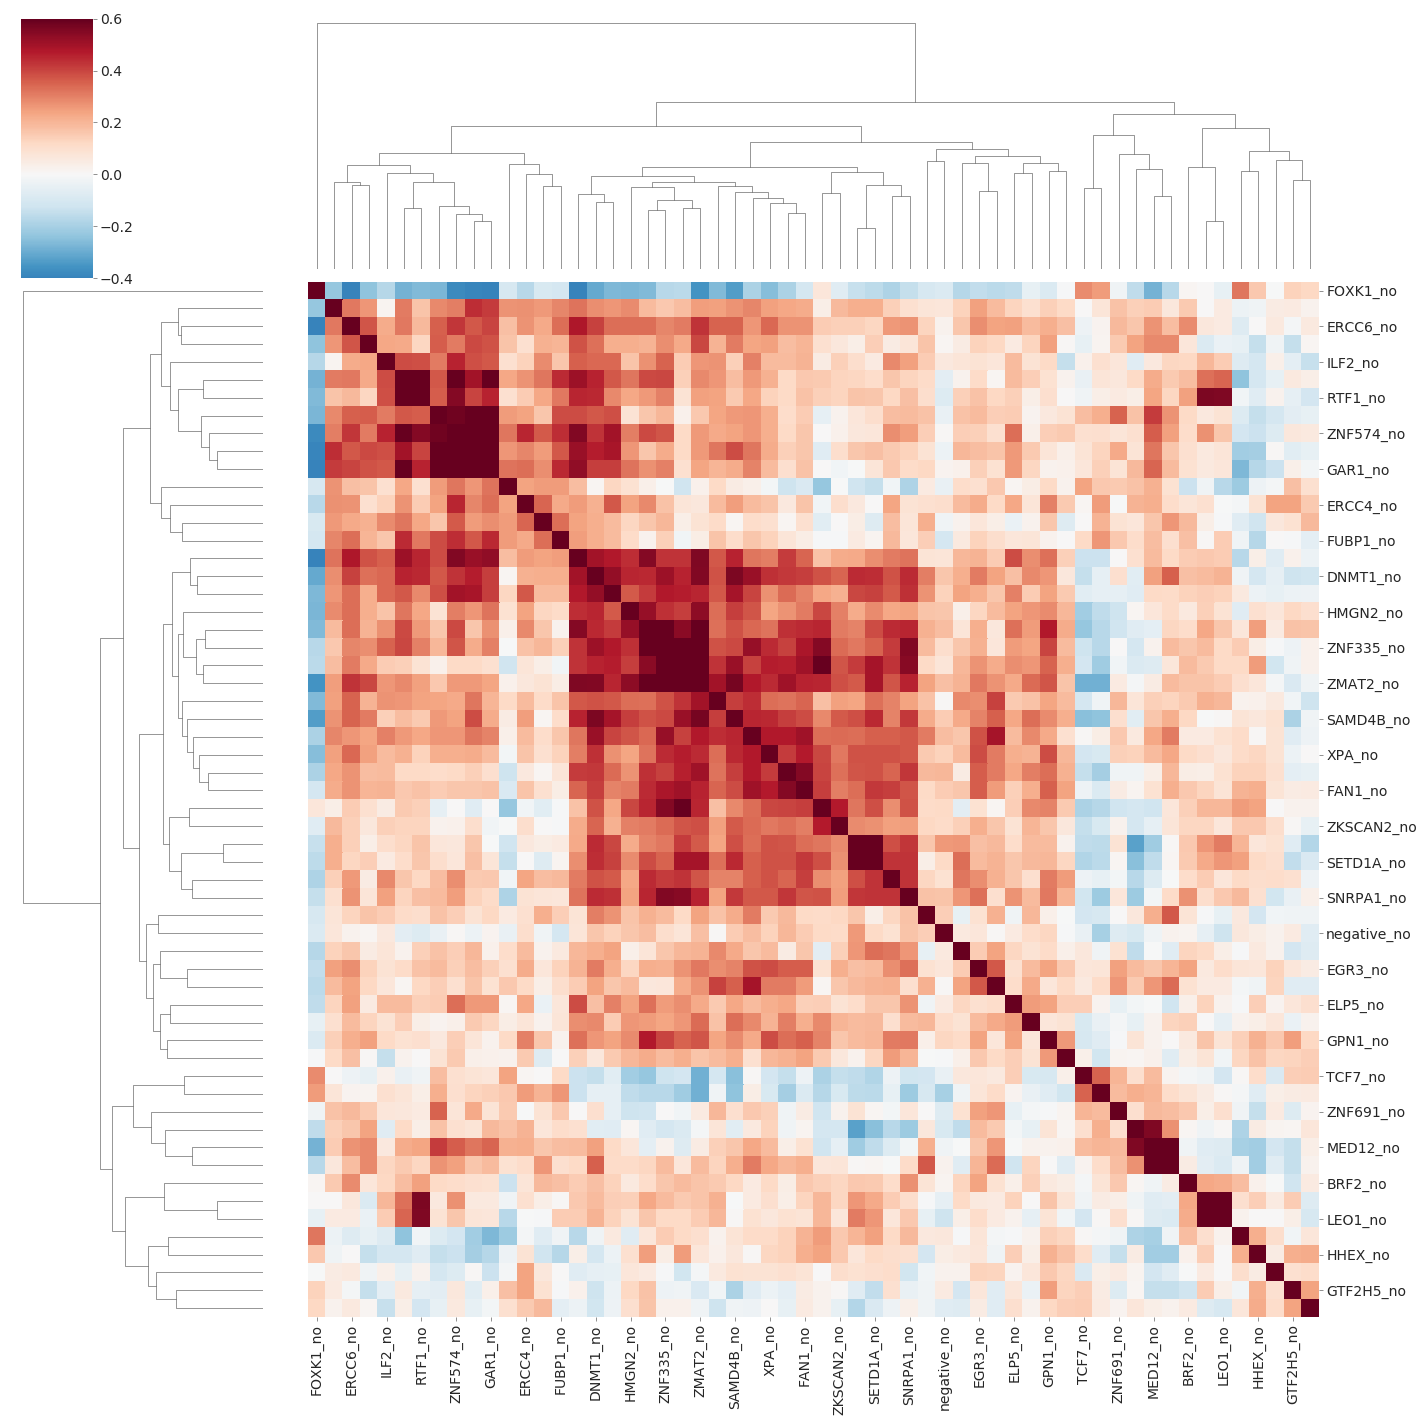

In [33]:
g = sns.clustermap(mean_pop_i_no.expression_table(cells=[i+'_no' for i in i_longexperiments_picked]+['negative_no'], genes=tree_genes_i_no)["weight"].corr(method='spearman'), robust=True, vmax=0.6, vmin=-0.4, figsize=(20, 20), cmap='RdBu_r', center=0)
fig = g.fig

In [34]:
%%capture

res = tree_selector(pop_a_no,
                    key='long_experiment',
                    num_features=200,
                    cells='guide_target in @a_longexperiments_picked',
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16, a_longexperiments_picked=a_longexperiments_picked)
tree_genes_a_no = res.selected_genes

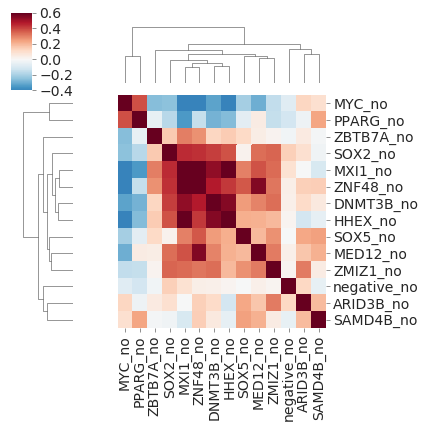

In [35]:
g = sns.clustermap(mean_pop_a_no.expression_table(cells=[i+'_no' for i in a_longexperiments_picked]+['negative_no'], genes=tree_genes_a_no)["weight"].corr(method='spearman'), robust=True, vmax=0.6, vmin=-0.4, figsize=(6, 6), cmap='RdBu_r', center=0)
fig = g.fig

In [36]:
# Focus on DNA repair targets
targets = ['ERCC6', 'ERCC4', 'SETD1A', 'BRCA1', 'XPA', 'BRCA2', 'ELOF1', 'POLR1D', 'GTF2H5', 'CPSF2', 'FAN1', 'ERCC8', 'LEO1', 'ZFP36L2', 'BOD1L1', 'HELQ', 'ZKSCAN2', 'TAF6L', 'HMGN2', 'TCF7', 'ZNF691', 'BRF2', 'SRSF7', 'GAR1', 'EGR3', 'ZNF839', 'FUBP1', 'MCM9', 'ZNF677']

In [37]:
%%capture

res = tree_selector(pop_i_no,
                    key='long_experiment',
                    num_features=200,
                    cells='guide_target in @targets',
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16, targets=targets)
tree_genes_i_no = res.selected_genes

In [38]:
%%capture

res = tree_selector(pop_i_cisplatin,
                    key='long_experiment',
                    num_features=200,
                    cells='guide_target in @targets',
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16, targets=targets)
tree_genes_i_cisplatin = res.selected_genes

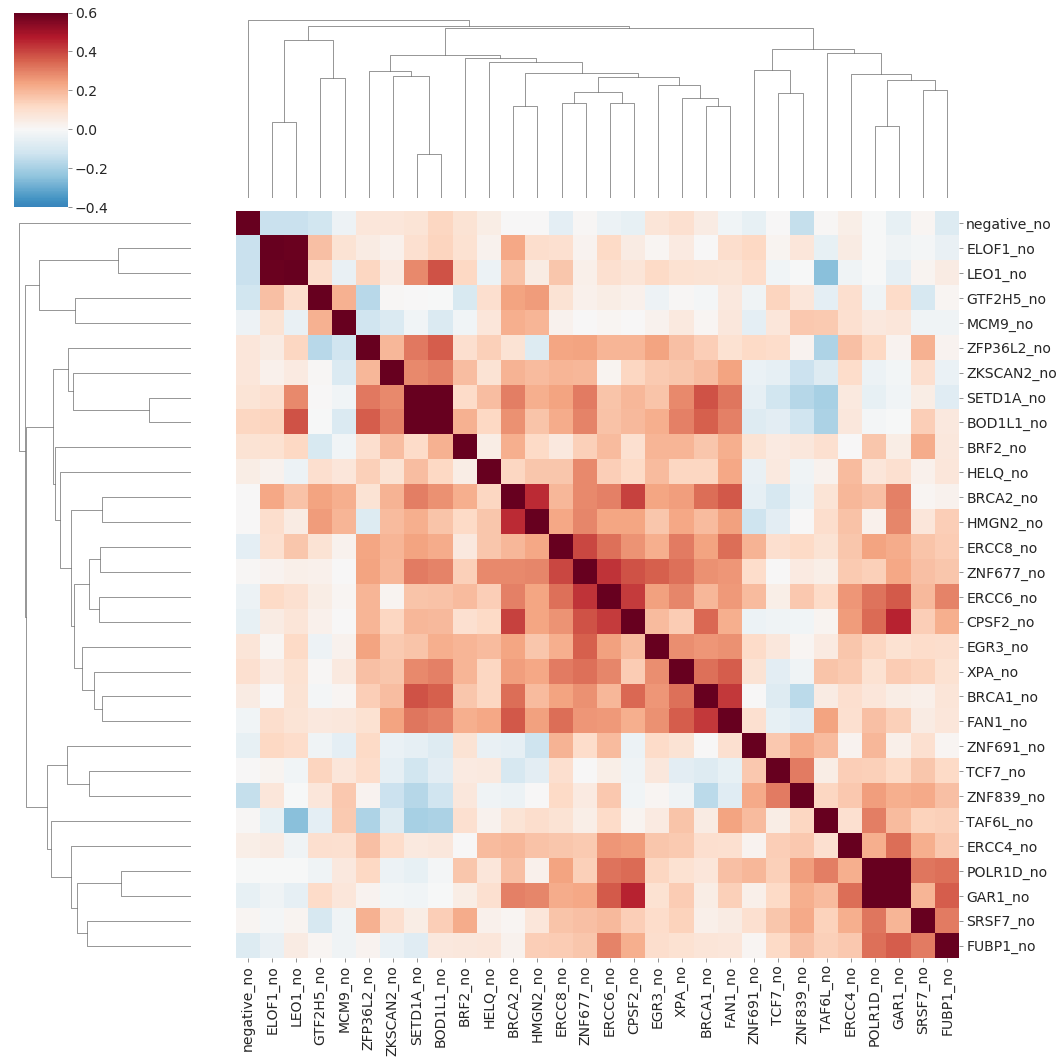

In [39]:
g = sns.clustermap(mean_pop_i_no.expression_table(cells=[i+'_no' for i in targets]+["negative_no"], genes=tree_genes_i_no.append(tree_genes_i_cisplatin))["weight"].corr(method='spearman'), robust=True, vmax=0.6, vmin=-0.4, figsize=(15, 15), cmap='RdBu_r', center=0)
fig = g.fig

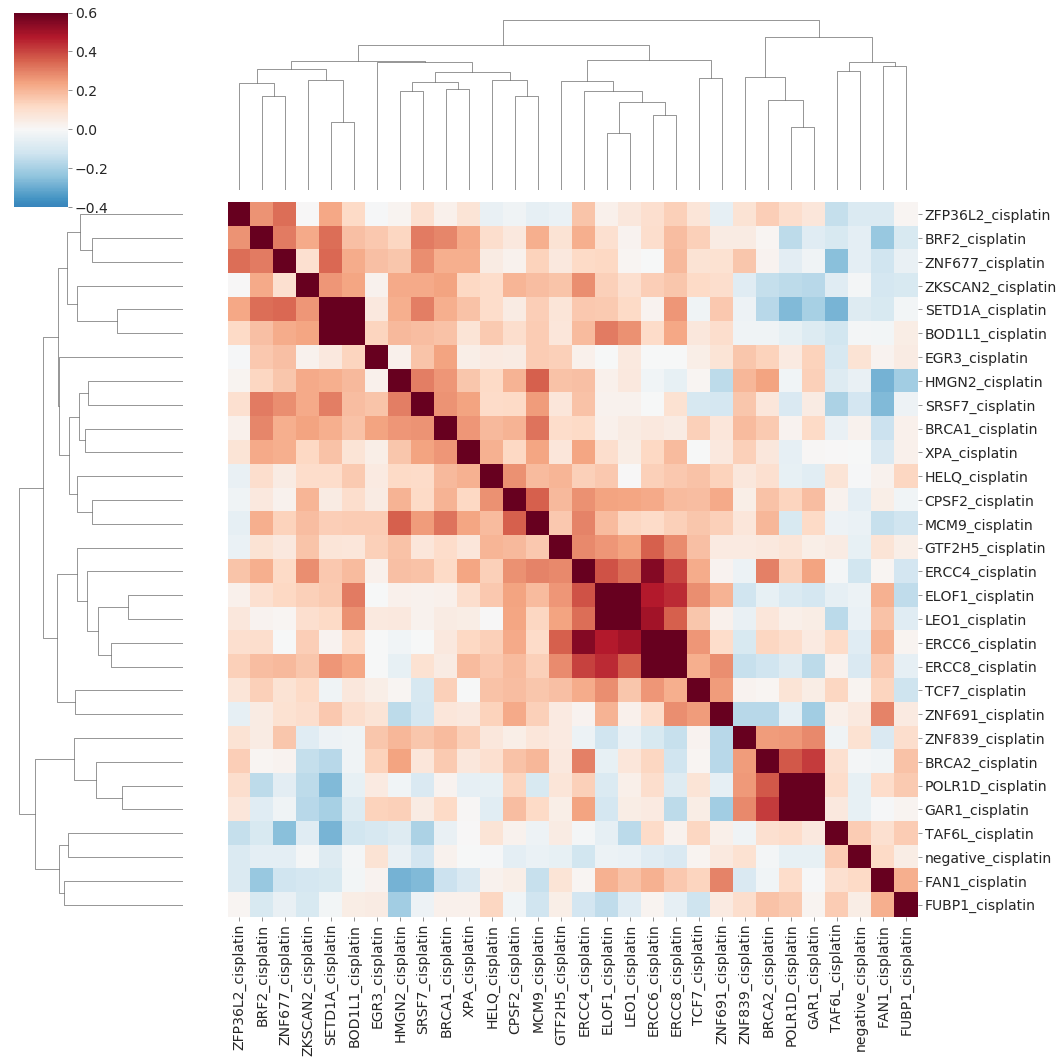

In [40]:
h = sns.clustermap(mean_pop_i_cisplatin.expression_table(cells=[i+'_cisplatin' for i in targets]+["negative_cisplatin"], genes=tree_genes_i_no.append(tree_genes_i_cisplatin))["weight"].corr(method='spearman'), robust=True, vmax=0.6, vmin=-0.4, figsize=(15, 15), cmap='RdBu_r', center=0)
fig = h.fig

In [41]:
# CRISPRa UMAP and cell cycle analysis

In [42]:
from matplotlib import cm, colors
vega_20 = list(map(colors.to_hex, cm.tab20.colors))

zeileis_28 = [
    "#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", "#4a6fe3",
    "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a", "#11c638", "#8dd593",
    "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7",
    "#f3e1eb", "#f6c4e1", "#f79cd4",
    '#7f7f7f', "#c7c7c7", "#1CE6FF", "#336600",  # these last ones were added,
]

In [43]:
%%capture

transformer = UMAP(n_neighbors=50, metric='correlation')
picked = ["negative", "MYC", "SAMD4B",  "ZBTB7A", "HHEX", "MXI1"]
pop_a_picked = pop_a.subpopulation(cells='guide_target in @picked and treatment == "no"', normalized_matrix='inherit', picked=picked)
res = tree_selector(pop_a_picked,
                    key='long_experiment',
                    num_features=100,
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16)

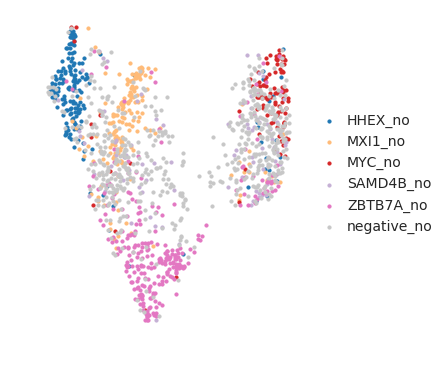

In [44]:
reduced = pop_a_picked.fit_transform(transformer,
                                  genes=res.selected_genes,
                                  normalized=True)
plt.figure(figsize=[6,6])
pop_a_picked.plot(reduced, 'long_experiment', cm=vega_20[::3], randomize_cmap=True)

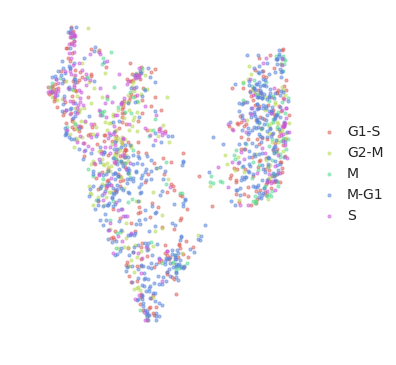

In [45]:
plt.figure(figsize=[6,6])
pop_a_picked.plot(reduced, 'cell_cycle_phase', alpha=0.5)

In [46]:
cell_cycle_table = pd.DataFrame()
picked = ["negative", "MYC", "SAMD4B",  "ZBTB7A", "HHEX", "MXI1"]

for guide in picked:
    cell_cycle_table[guide] = pop_a.cells[pop_a.cells["guide_target"] == guide]["cell_cycle_phase"].value_counts(normalize=True)
cell_cycle_table = cell_cycle_table.T[["S", "M-G1", "M", "G2-M", "G1-S"]]
cell_cycle_table = cell_cycle_table[["M", "M-G1", "G1-S", "S", "G2-M"]]
cell_cycle_table = (cell_cycle_table - cell_cycle_table.loc["negative"])/cell_cycle_table.loc["negative"]

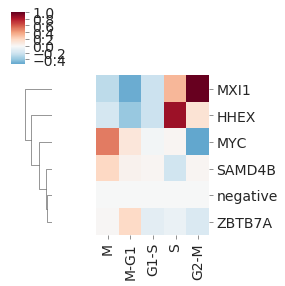

In [47]:
g = sns.clustermap(cell_cycle_table, cmap = 'RdBu_r',  center=0, robust=True,  col_cluster=False, figsize=[4,4])
fig = g.fig